# BCycle all-data EDA 

This notebook explores the entire dataset provided from BCycle. This dataset has the following columns:

* `Membership Type`: Text categorical column. Some memberships were renamed during the course of BCycle's operation.
* `Bike`: Integer identifier for the bike used in each trip.
* `Checkout Date`: MM/DD/YY formatted date of the checkout
* `Checkout Time`: HH:MM AM/PM formatted time of the checkout.
* `Checkout Kiosk`: The kiosk where the bike trip started.
* `Return Kiosk`: The kiosk where the bike trip ended.
* `Duration (Minutes)`:  Integer length of bike trip (rounded?).


## Imports and data loading

Before getting started, let's import some useful libraries for visualization, and the bcycle utils library.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
plt.rc('xtick', labelsize=14) 
plt.rc('ytick', labelsize=14) 

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## Helper functions

Before getting started on the data analysis, let's define a few useful functions we can call to plot data and reproduce the same analysis.

In [52]:
def plot_lines(df, subplots, title, xlabel, ylabel):
    '''Generates one or more line plots from pandas dataframe'''
    
    fig, ax = subplots
    ax = df.plot.line(ax=ax)
    ax.set_xlabel(xlabel, fontdict={'size' : 14})
    ax.set_ylabel(ylabel, fontdict={'size' : 14})
    ax.set_title(title, fontdict={'size' : 18}) 
    ttl = ax.title
    ttl.set_position([.5, 1.02])
    ax.tick_params(axis='x', labelsize=14)
    ax.tick_params(axis='y', labelsize=14)   


# Processing Time and Date

First up is the date and time information. The `checkout_date` column is stored as a date in Excel, so it automatically converts it to `datetime` in pandas. But the `checkout_time` column is stored as text, so we need to convert it. 

After we combine the date and time, we can set this as the index of the dataframe which let us use all the next pandas timeseries functions.

In [103]:
trip_df = pd.read_csv('../input/all_trips.csv')

# Clean up column names
trip_df.columns = ['membership', 'bike_id', 'checkout_date', 'checkout_time', 'checkout_kiosk', 'return_kiosk', 'duration']

# Combine the date and time columns, use this as the index
def combine_date_time(df, new_col, date_col, time_col, set_index=True, drop=True):
    '''Combines `date_col` and `time_col` into a single datetime column
    INPUT: df - Dataframe to operate on
           date_col - string name of the date column
           time_col - string name of the time column
           set_index - bool whether to set as index after combining
           drop - bool whether to drop original columns afterwards
    RETURNS: Transformed dataframe
    '''

    df['datetime'] = pd.to_datetime(df[date_col] + ' ' + df[time_col])
    # trip_df = trip_df.sort_values('datetime')
    if set_index:
        df = df.set_index(new_col, drop=True)
    
    if drop:
        df = df.drop([date_col, time_col], axis=1)

    return df
    
    
trip_df = combine_date_time(trip_df, new_col='datetime', date_col='checkout_date', time_col='checkout_time')
print('Dataframe shape is {}'.format(trip_df.shape))
trip_df.head()

Dataframe shape is (529810, 5)


,membership,bike_id,checkout_kiosk,return_kiosk,duration
datetime,,,,,
2013-12-21 09:09:00,Founding Member (Austin B-cycle),966,4th & Congress,Republic Square,5
2013-12-21 18:36:00,Annual Membership (Austin B-cycle),453,South Congress & Elizabeth,5th & Bowie,10
2013-12-21 18:04:00,Founding Member (Austin B-cycle),116,2nd & Congress,4th & Congress,5
2013-12-21 17:56:00,Founding Member (Austin B-cycle),971,5th & Bowie,2nd & Congress,7
2013-12-21 17:49:00,24-Hour Kiosk (Austin B-cycle),14,Barton Springs & Riverside,City Hall / Lavaca & 2nd,6


### Plotting weekly rentals

Let's plot the weekly rentals, to get a feel for how the data varies

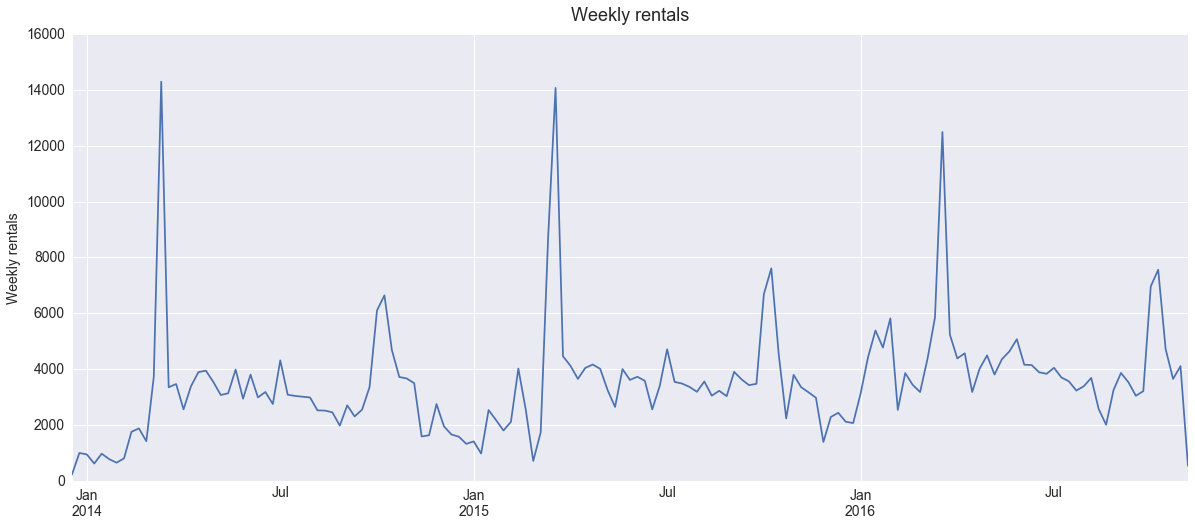

In [104]:
trip_df.resample('W').size().head()
plot_lines(trip_df.resample('W').size(), 
           plt.subplots(1,1, figsize=(20,8)), 
                        title='Weekly rentals', 
                        xlabel='', ylabel='Weekly rentals')



The rentals show that over the period of 3 years, the amount of rentals is increasing slightly, with 2014 rentals averaging around 3000 per week, 2015 is just under 4000, and 2016 is over 4000. There are also monthly variations, presumably due to the weather.

There are two obvious outliers in the rentals graph which happen every year around the same time. 

* The first is in mid-March, which corresponds to the [SXSW Festival](https://www.sxsw.com). This festival lasts for 7 - 10 days and is split between Interactive, Film, and Music tracks. The Interactive festival is centred on the Austin Convention Center, and during the Music section many venues all around the downtown area and East 6th Street play host to new bands. The peak rentals is ~14000 in both 2014 and 2015, dropping slightly to ~12000 in 2016.


* The second is in early October, when the [ACL Festival](https://www.aclfestival.com) happens. This is a huge music festival split over the first two weekends in October. The festival is held at Zilker Park. This peak is around ~6500 in 2014, increasing to just under 8000 in 2015 and 2016.

# Processing Memberships

The BCycle Membership scheme has been revamped several times during the course of the program. To keep the analysis simple, let's group the membership types into the following categories. We'll use some regexes to combine the categories, to make it more readable I included '...' below to show it matches any following characters.

* `Single` <- 'Ridescout Single Ride', 'Try Before You Buy Special'
* `Day` <- '24-Hour ...', 'Explorer ...', 'Walk up ...'
* `Weekend` <- 'ACL Weekend Pass ...', 'FunFunFun ...', 'Weekender ...'
* `Weekly` <- '7-Day ...'
* `Monthly` <- 'Local30 ...'
* `Semester` <- 'Semester ...'
* `Annual` <- 'Annual ...', 'Local365 ...', 'Membership: pay once  one-year commitment', 'Republic Rider'
* `Tri-Annual` <- 'Founding Member ...'

There are a couple of other types labelled as `PROHIBITED` (8) and `RESTRICTED` (10). We'll drop these as there are only a small number of them, and many of these trips were 0 minutes long.

In [109]:
def clean_memberships(df, col):
    '''Cleans memberships by consolidating and converting to categories
    INPUT: df - pandas Dataframe containing membership columns
           col - column name to be consolidated
    RETURNS: pandas DataFrame with consolidated memberships'''
    
    # Replace the various memberships with their groupings
    df[col] = df[col].astype(str)
    df[col] = df[col].replace(['RideScout Single Ride','Try Before You Buy Special'], value='single')
    df[col] = df[col].replace(['^24-Hour.*$', '^Explorer.*$', '^Walk Up$'], value='day', regex=True)
    df[col] = df[col].replace(['^ACL Weekend Pass.*$', '^FunFunFun.*$', '^Weekender.*$'], value='weekend', regex=True)
    df[col] = df[col].replace(['^7-Day.*$'], value='week', regex=True)
    df[col] = df[col].replace(['^Local30.*$'], value='month', regex=True)
    df[col] = df[col].replace(['^Semester.*$'], value='semester', regex=True)
    df[col] = df[col].replace(['^Annual.*$', '^Local365.*$', 'Republic Rider.*$', '^Membership: pay once  one-year.*$'], value='year', regex=True)
    df[col] = df[col].replace(['^Founding Member.*$'], value='triannual', regex=True)

    # Drop the remaining trips (PROHIBITED and RESTRICTED)
    drop_mask = (df['membership'] == 'PROHIBITED') | (df['membership'] == 'RESTRICTED')
    df = df[~drop_mask]
    
    # Finally convert to categorical
    df[col] = df[col].astype('category')
    return df
    
trip_df = clean_memberships(trip_df, 'membership')

print(trip_df.groupby('membership').size())
print(trip_df.info())


membership
day          340573
month         26340
semester       3326
single          793
triannual      6288
week           5897
weekend       13323
year         133252
dtype: int64
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 529792 entries, 2013-12-21 09:09:00 to 2016-10-31 11:35:21
Data columns (total 5 columns):
membership        529792 non-null category
bike_id           529792 non-null object
checkout_kiosk    529792 non-null object
return_kiosk      529792 non-null object
duration          529792 non-null int64
dtypes: category(1), int64(1), object(3)
memory usage: 20.7+ MB
None


With the hard work out of the way, let's visualize the membership to see what's going on.

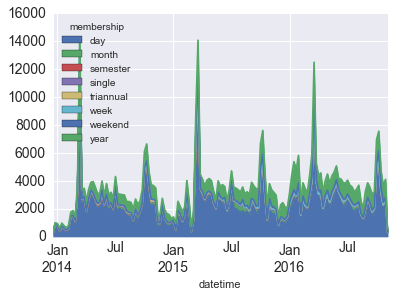

In [132]:
plot_df = trip_df.copy()
plot_df = plot_df.sort_index()
plot_df = plot_df.pivot_table(values='bike_id', columns='membership', index=plot_df.index, aggfunc='count')
plot_df = plot_df.resample('W').sum()
plot_df = plot_df.fillna(0)
plot_df.head(120)

plot_df.plot.area(figsize(20,10))

In [139]:
group_df = trip_df.groupby('membership')
group_df.head()

,membership,bike_id,checkout_kiosk,return_kiosk,duration
datetime,,,,,
2013-12-21 09:09:00,triannual,966,4th & Congress,Republic Square,5
2013-12-21 18:36:00,year,453,South Congress & Elizabeth,5th & Bowie,10
2013-12-21 18:04:00,triannual,116,2nd & Congress,4th & Congress,5
2013-12-21 17:56:00,triannual,971,5th & Bowie,2nd & Congress,7
2013-12-21 17:49:00,day,14,Barton Springs & Riverside,City Hall / Lavaca & 2nd,6
2013-12-21 17:44:00,day,421,Convention Center / 4th St. @ MetroRail,Republic Square,10
2013-12-21 17:38:00,year,646,South Congress & James,South Congress & Elizabeth,4
2013-12-21 17:36:00,day,354,City Hall / Lavaca & 2nd,Barton Springs & Riverside,30
2013-12-21 17:34:00,day,287,Republic Square,Convention Center / 4th St. @ MetroRail,14


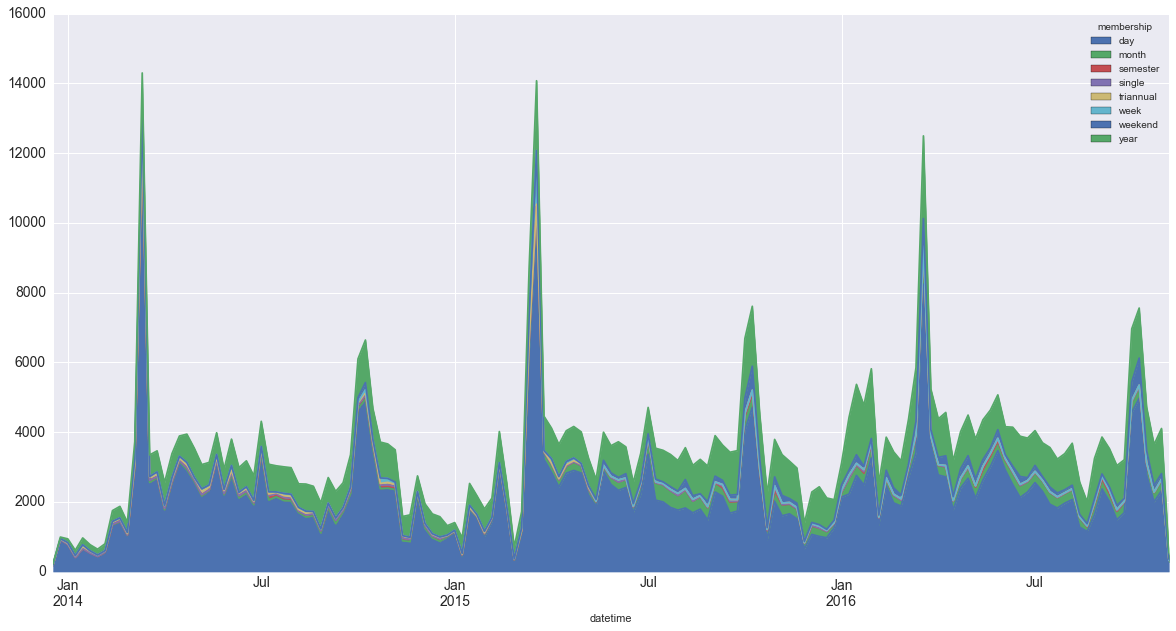

In [136]:
plot_df.plot.area(figsize=(20,10))

In [13]:
# There are some strange values in the bike_id column !
# trip_df['bike_id'] = trip_df['bike_id'].astype(np.int32)

# Find all the bike_id values that aren't numeric
print('Checking for non-numeric bike ids:')
text_bikes_df = trip_df[trip_df['bike_id'].str.contains('\D')]
bike_str_ids = text_bikes_df['bike_id'].unique()
text_bikes_df.groupby('bike_id').size()

Checking for non-numeric bike ids:


bike_id
198BB      683
Block01      7
Block02     15
Block03      4
Block04     10
Block05      6
dtype: int64

In [20]:
text_bikes_df.sort_values('bike_id', ascending=False)

,membership,bike_id,checkout_kiosk,return_kiosk,duration
datetime,,,,,
2016-10-29 14:35:53,Local365,Block05,Barton Springs Pool,Barton Springs Pool,1
2015-11-25 20:00:48,Local365,Block05,Davis at Rainey Street,Davis at Rainey Street,0
2015-10-15 16:02:15,Weekender,Block05,Davis at Rainey Street,Davis at Rainey Street,0
2015-10-17 21:50:37,Walk Up,Block05,Davis at Rainey Street,Davis at Rainey Street,0
2014-03-13 02:44:00,24-Hour Kiosk (Austin B-cycle),Block05,State Capitol Visitors Garage @ San Jacinto & ...,State Capitol Visitors Garage @ San Jacinto & ...,0
2015-11-12 10:08:54,Walk Up,Block05,Davis at Rainey Street,Davis at Rainey Street,0
2016-07-06 08:15:12,Walk Up,Block04,Zilker Park,Zilker Park,0
2016-02-16 23:29:59,Weekender ($15 plus tax),Block04,Red River & 8th Street,Red River & 8th Street,1
2014-10-28 16:31:00,7-Day Membership (Austin B-cycle),Block04,4th & Congress,4th & Congress,0


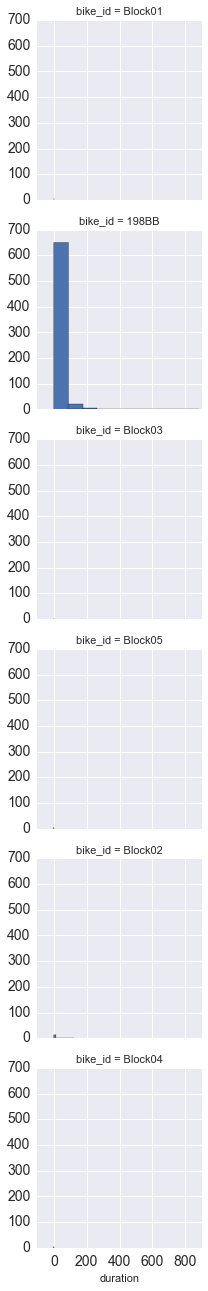

In [17]:
g = sns.FacetGrid(text_bikes_df, row="bike_id")
g = g.map(plt.hist, "duration")